# Tasca S11.01. Visualització de Dades amb Python i Power BI

Proyecto de visualización de datos aplicando el lenguaje de programación Python con las librerías Pandas, Matplotlib, Seaborn y Plotly, así como su integración con Power BI.

In [1]:
import mysql.connector
from dotenv import load_dotenv
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats
import datetime

## Nivell 1

### 1. 
Connecta Python amb MySQL Workbench i carrega les dades de la teva base de dades del Sprint 4 per utilitzar-les en tots els exercicis.

In [2]:
load_dotenv()  

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")

In [3]:
try:
    # nos conectamos a la base de datos
    connection = mysql.connector.connect(user=DB_USER, password=DB_PASSWORD, host=DB_HOST, database='s4_database')
    # obtenemos información de la base de datos
    db_Info = connection.server_info
    print("Connected to MySQL Server version ", db_Info)
    cursor = connection.cursor()
    cursor.execute("select database();")
    record = cursor.fetchone()
    print("You're connected to database: ", record)

    # Columnas necesarias para cada figura
    # transactions.amount
    # transactions.amount, products.price
    # users.country
    # products.colour, products.price
    # users.country, products.colour
    # transactions.amount, products.price, products.weight, products.colour

    cursor = connection.cursor()
    # cursor.execute("SELECT amount FROM transactions WHERE declined=0")
    cursor.execute("SELECT t.id,amount,price,weight,colour,country,birth_date FROM transactions AS t " \
    "INNER JOIN users AS u ON t.user_id=u.id " \
    "INNER JOIN transaction_product AS tp ON t.id=tp.transaction_id " \
    "INNER JOIN products AS p ON tp.product_id=p.id " \
    "WHERE declined=0")
    # obtenemos todos los registros
    records = cursor.fetchall()
    print("Total number of rows in table: ", cursor.rowcount)
    # creamos el DataFrame transactions_products_users
    tpu = pd.DataFrame(records, columns=['transaction_id', 'amount', 'price', 'weight', 'colour', 'country', 'birthdate'])
    display(tpu.head(3))

except mysql.connector.Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.44
You're connected to database:  ('s4_database',)
Total number of rows in table:  252693


,transaction_id,amount,price,weight,colour,country,birthdate
0,00043A49-2949-494B-A5DD-A5BAE3BB19DD,395.43,$96.26,1.5,#e2e2e2,France,"Jan 28, 1996"
1,00043A49-2949-494B-A5DD-A5BAE3BB19DD,395.43,$180.91,3,#666666,France,"Jan 28, 1996"
2,00043A49-2949-494B-A5DD-A5BAE3BB19DD,395.43,$65.25,1,#bababa,France,"Jan 28, 1996"


MySQL connection is closed


### 2. 
Per a cada ítem, crea una visualització adequada segons les variables especificades. Interpreta els resultats segons les teves dades.

Recorda: quan seleccionis les columnes, pensa sempre en el mètode que faràs servir i inclou les que calguin per a la funció de visualització que vulguis utilitzar.

* Una variable numèrica.
* Dues variables numèriques.
* Una variable categòrica.
* Una variable categòrica i una numèrica.
* Dues variables categòriques.
* Tres variables combinades.
* Crea un Pairplot.

#### 1. Una variable numérica
En esta figura decidimos hacer un histograma de la columna amount de transactions. Debido a como esta elaborado nuestro query de SQL y DataFrame, primero tuvimos que filtrar el DF de tal forma que solo apareciera de forma única cada combinación de transaction_id y amount.

Como podemos ver en la figura resultante, la mayor parte de las ventas son de un tamaño menor a 400€, destacando las de valor 180-200€. Hay una caída notable que comienza un poco antes de llegar a los 400€.

,transaction_id,amount,price,weight,colour,country,birthdate
0,00043A49-2949-494B-A5DD-A5BAE3BB19DD,395.43,$96.26,1.5,#e2e2e2,France,"Jan 28, 1996"
4,000447FE-B650-4DCF-85DE-C7ED0EE1CAAD,155.63,$57.25,1.2,#b7b7b7,Italy,"Aug 16, 1957"
7,00045D6B-ED2E-4F2F-8186-CEE074D875D0,326.01,$79.53,0.8,#606060,United States,"Sep 4, 1995"


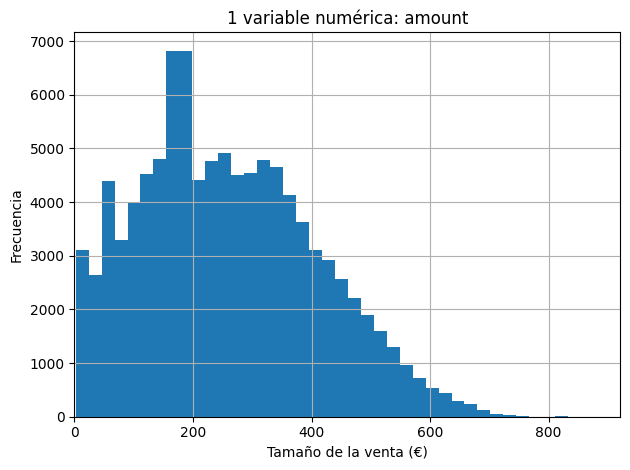

In [4]:
# convertimos el tipo de datos de la columna a numérico
if tpu.dtypes['amount'] == 'object':
    tpu['amount'] = pd.to_numeric(tpu['amount'])
# filtramos el DataFrame tpu para eliminar repeticiones:
tpu_filtrado = tpu[~tpu[['transaction_id','amount']].duplicated(keep='first')]
display(tpu_filtrado.head(3))
# elaboramos la figura
plt.figure()
tpu_filtrado['amount'].plot(kind='hist', bins=40, grid=True)
plt.title('1 variable numérica: amount')
plt.ylabel('Frecuencia')
plt.xlabel('Tamaño de la venta (€)')
plt.xlim(left=0)
plt.tight_layout()
plt.show()
plt.close()

#### 2. Dues variables numèriques.
En esta figura, mostramos la columna amount de transactions vs. la columna price de products. Se muestra el precio de productos que se han comprado para cada tamaño de venta.

Podemos observar como existe la relación lineal al inicio (no podemos tener ventas de cierto tamaño para productos de precio mayor a la venta.) Lo más interesante son que productos se venden para las ventas más altas, destacando principalmente aquellos que puntos más intensos.

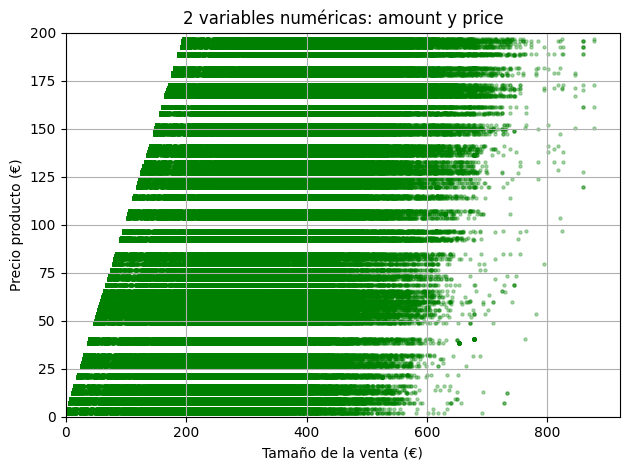

In [5]:
# convertimos el tipo de datos de la columna a numérico
if tpu.dtypes['price'] == 'object':
    tpu['price'] = pd.to_numeric(tpu['price'].str.replace('$',''))
# elaboramos la figura
plt.figure()
plt.scatter(tpu['amount'], tpu['price'], alpha=0.3, s=5, c='g')
plt.grid()
plt.title('2 variables numéricas: amount y price')
plt.xlabel('Tamaño de la venta (€)')
plt.ylabel('Precio producto (€)')
plt.xlim(left = 0)
plt.ylim(0, 200)
plt.tight_layout()
plt.show()
plt.close()

#### 3. Una variable categòrica.
En esta figura, mostramos la distribución de valores de la columna users.country. Por cada país, mostramos el número de ventas que los usuarios han realizado.

La mayor concentración de ventas se da en Estados Unidos, seguida por Canadá y Reino Unido, mientras que el resto de países presentan niveles bastante similares entre sí.

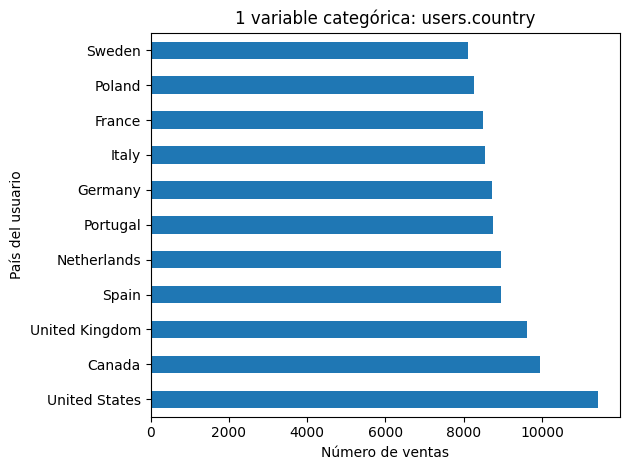

In [6]:
plt.figure()
# elaboramos la figura, eliminando valores duplicados
tpu_filtrado['country'].value_counts().plot.barh()
plt.title('1 variable categórica: users.country')
plt.xlabel('Número de ventas')
plt.ylabel('País del usuario')
plt.tight_layout()
plt.show()
plt.close()

#### 4. Una variable categòrica i una numèrica.
En esta figura, mostramos el precio medio de los productos según su color. 

Como podemos ver, el precio medio varia mucho según el color utilizado.

In [7]:
colour_price = tpu.groupby('colour')['price'].mean().sort_values()

fig = px.bar(
    x=colour_price.values,
    y=colour_price.index,
    orientation='h',
    labels={'x': 'Precio medio (€)', 'y': 'Color'},
    title='1 variable categórica y 1 numérica: colour, mean price'
)

fig_height = max(400, len(colour_price) * 20) 
fig.update_layout(height=fig_height)

fig.show()

#### 5. Dues variables categòriques.
En esta figura, mostramos la cantidad de productos de cierto color que se han vendido en cada país, para los 10 colores con un precio medio más alto. 

Observamos como hay claramente un color mucho más vendido que el resto.

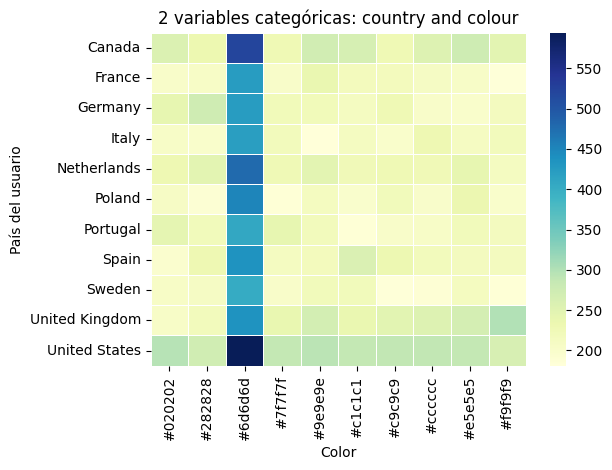

In [8]:
# comparamos solo los 10 primeros colores con precio medio más alto
heatmap_data = pd.crosstab(tpu['country'], tpu[tpu['colour'].isin(colour_price.index[:10])]['colour'])

plt.figure()
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
plt.title('2 variables categóricas: country and colour')
plt.xlabel('Color')
plt.ylabel('País del usuario')
plt.tight_layout()
plt.show()
plt.close()

#### 6. Tres variables combinades.
En esta figura, mostramos la distribución del tamaño de la venta por cada país del usuario, comparando el color con un precio medio más alto y el color con el precio medio más bajo.

Para todos los países, observamos que la mayor parte de las ventas del primer color se hacen en ventas de un tamaño promedio menor al color con un precio medio más bajo. Esto nos indica que el color con precio medio más bajo se compra más en ventas de tamaño más grande.

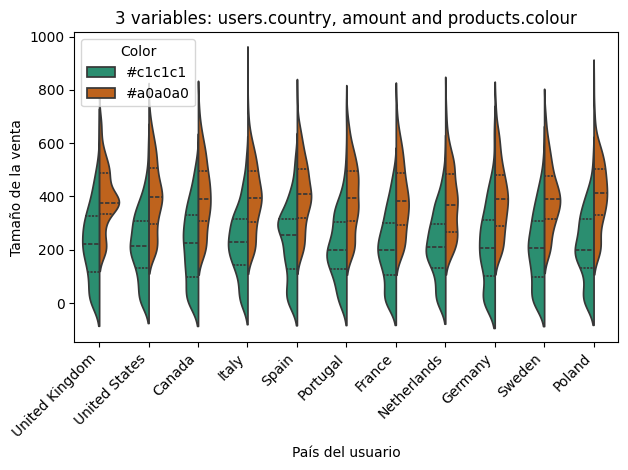

In [9]:
first_last_colour = colour_price.index[:1].append(colour_price.index[-1:])
violin_data = tpu[tpu['colour'].isin(first_last_colour)][['country','amount','colour']]

plt.figure()
sns.violinplot(
    data=violin_data,
    x='country',
    y='amount',
    hue='colour',
    split=True,       # overlay two categories per amount if only 2 colours
    palette='Dark2',
    inner="quartile"
)
plt.title('3 variables: users.country, amount and products.colour')
plt.xlabel('País del usuario')
plt.ylabel('Tamaño de la venta')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Color')
plt.tight_layout()
plt.show()
plt.close()

#### 7. Crea un Pairplot.
En esta figura, elaboramos un Pairplot de la cantidad de la transacción, el precio del producto y 
su peso. Además, utilizamos los 3 primeros (tonos azules) y 3 últimos (tonos rojos) colores según 
el precio medio.

Podemos observar grandes diferencias en el comportamiento de los productos según si son primeros o
últimos.

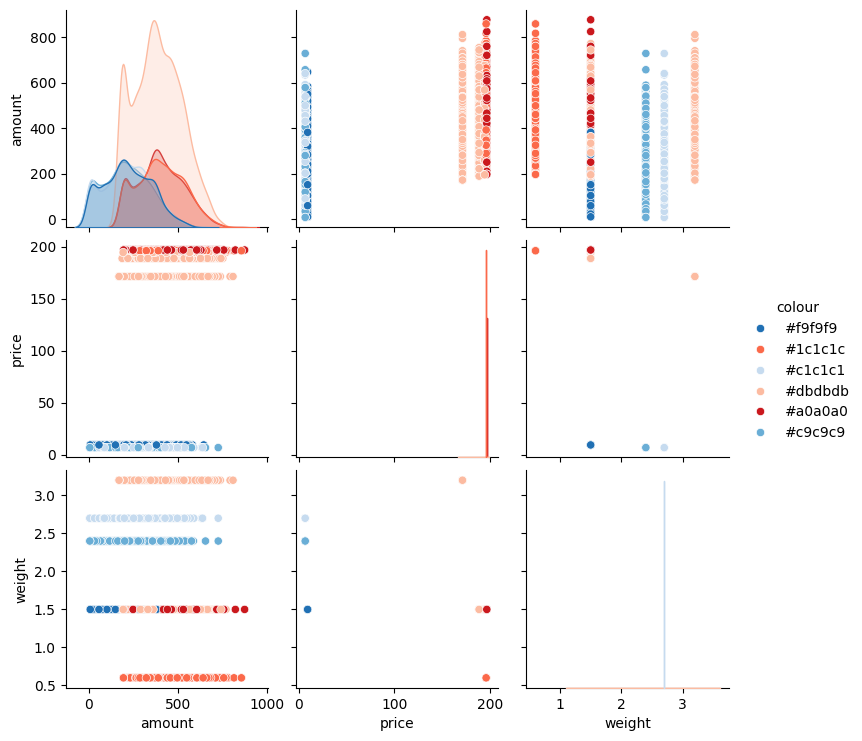

In [10]:
# convertimos la columna weight a numérico
if tpu.dtypes['weight'] == 'object':
    tpu['weight'] = pd.to_numeric(tpu['weight'])

# elegimos los 3 primeros y 3 últimos productos por precio medio
# print(colour_price.index[:3])
# print(colour_price.index[-3:])
colours_chosen = colour_price.index[:3].append(colour_price.index[-3:])
pairplot_data = tpu[tpu['colour'].isin(colours_chosen)][['amount', 'price', 'weight', 'colour']]

# creamos palette para que sea más fácil diferenciar los colores
palette = sns.color_palette("Blues", n_colors=3) + sns.color_palette("Reds", n_colors=3)
palette_dict = dict(zip(colours_chosen, palette))

pairplot = sns.pairplot(pairplot_data, vars=['amount', 'price', 'weight'], 
            hue='colour', palette=palette_dict, diag_kind='kde')#, height=2.5)
plt.show()

## Nivell 2

### 1. 
Representa la correlació d'algunes variables i interpreta els resultats segons les teves dades.

Columna weight es:
stat=408296.038, p=0.000
Probablemente no Gaussiana
Columna price es:
stat=1314322.063, p=0.000
Probablemente no Gaussiana
Relación lineal:
stat=0.105, p=0.000
Probablemente dependiente.


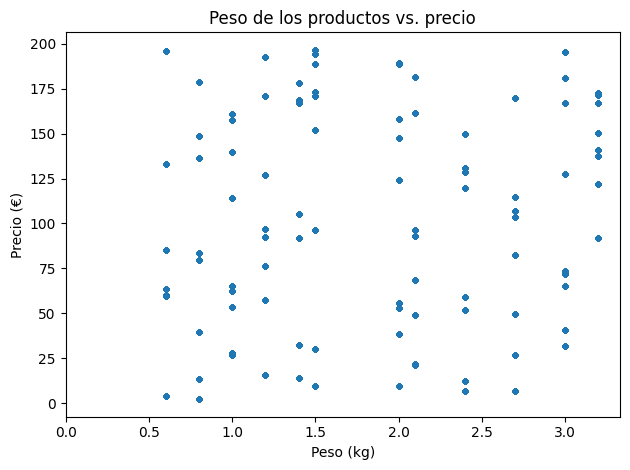

In [11]:
def K2_Test(data):
    '''Función que prueba si los datos tienen una distribución Gaussiana o no.'''
    stat, p = scipy.stats.normaltest(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probablemente Gaussiana')
    else:
        print('Probablemente no Gaussiana')

def pearsonr_correlation(data1,data2):
    """Función que prueba si hay relación lineal entre los datos."""
    stat, p = scipy.stats.pearsonr(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probablemente independiente.')
    else:
        print('Probablemente dependiente.')

print('Columna weight es:')
K2_Test(tpu['weight'])
print('Columna price es:')
K2_Test(tpu['price'])
print('Relación lineal:')
pearsonr_correlation(tpu['weight'], tpu['price'])
	
plt.figure()
plt.scatter(tpu['weight'], tpu['price'], s=10)
plt.title('Peso de los productos vs. precio')
plt.xlabel('Peso (kg)')
plt.ylabel('Precio (€)')
plt.xlim(left = 0)
plt.tight_layout()
plt.show()
plt.close()

En la figura anterior, podemos ver que no hay ninguna correlación entre peso y precio. Además, hicimos el D’Agostino’s K^2 Test y comprobamos que ninguna de las dos distribuciones es Gaussiana.

C:\Users\arman\AppData\Local\Temp\ipykernel_7452\1379610524.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arman\AppData\Local\Temp\ipykernel_7452\1379610524.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Columna age es:
stat=69611.478, p=0.000
Probablemente no Gaussiana
Columna price es:
float64
stat=540708.612, p=0.000
Probablemente no Gaussiana
Relación lineal:
stat=-0.003, p=0.385
Probablemente independiente.


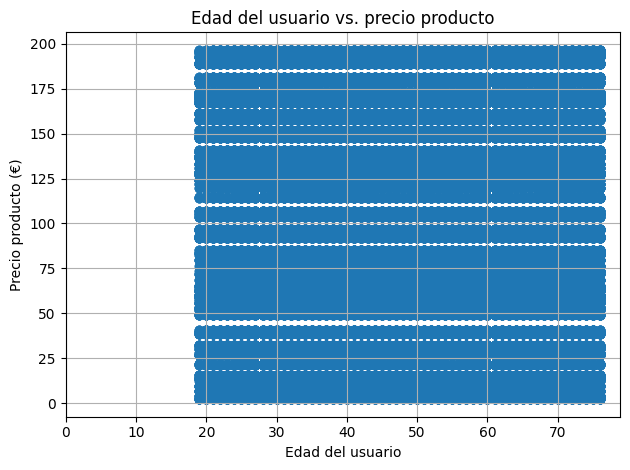

In [12]:
def edad_actual(fecha, nacimiento):
    '''
    Función que calcula la edad de un usuario respecto a una fecha, 
    que debe tener el formato "%Y-%m-%d" o ser un datetime.
    '''
    if isinstance(fecha, str):
        try:
            fecha = datetime.datetime.strptime(fecha, "%Y-%m-%d")
        except:
            print('Hay un error en el formato de la fecha.')
    
    edad = fecha - nacimiento
    if edad < datetime.timedelta():
        print('El usuario aún no había nacido')
        return
    
    return round(edad.total_seconds() / (365.25 * 24 * 60 * 60))

# convertimos birthdate a datetime y creamos columna de edad de usuario
if not(isinstance(tpu_filtrado.loc[0,'birthdate'], datetime.datetime)):
    tpu_filtrado.loc[:,'birthdate'] = [datetime.datetime.strptime(date_str, "%b %d, %Y") for date_str in tpu_filtrado['birthdate']]
    # creamos la columna age
    tpu_filtrado['age'] = [edad_actual(datetime.datetime.now(),nacimiento) for nacimiento in tpu_filtrado['birthdate']]

# convertimos el tipo de datos de la columna a numérico
if tpu_filtrado.dtypes['price'] == 'object':
    tpu_filtrado['price'] = (tpu_filtrado['price'].str.replace(r'[^\d.]', '', regex=True).astype(float))
# if not isinstance(tpu_filtrado.loc[0,'price'], float):
#     tpu_filtrado.loc[:,'price'] = pd.to_numeric(tpu_filtrado['price'].str.replace('$',''))

print('Columna age es:')
K2_Test(tpu_filtrado['age'])
print('Columna price es:')
print(tpu_filtrado['price'].dtype)
K2_Test(tpu_filtrado['price'])
print('Relación lineal:')
pearsonr_correlation(tpu_filtrado['age'], tpu_filtrado['price'])

plt.figure()
plt.scatter(tpu_filtrado['age'], tpu_filtrado['price'])
plt.grid()
plt.title('Edad del usuario vs. precio producto')
plt.xlabel('Edad del usuario')
plt.ylabel('Precio producto (€)')
plt.xlim(left = 0)
plt.tight_layout()
plt.show()
plt.close()

No parece existir ninguna correlacion entre la edad del usuario y el precio de los productos que compran. Los usuarios de cualquier edad compran productos de cualquier precio. Además, hicimos el D’Agostino’s K^2 Test y comprobamos que ninguna de las dos distribuciones es Gaussiana.

### 2. 
Implementa un Jointplot per explorar la relació entre dues variables i interpreta els resultats segons les teves dades.

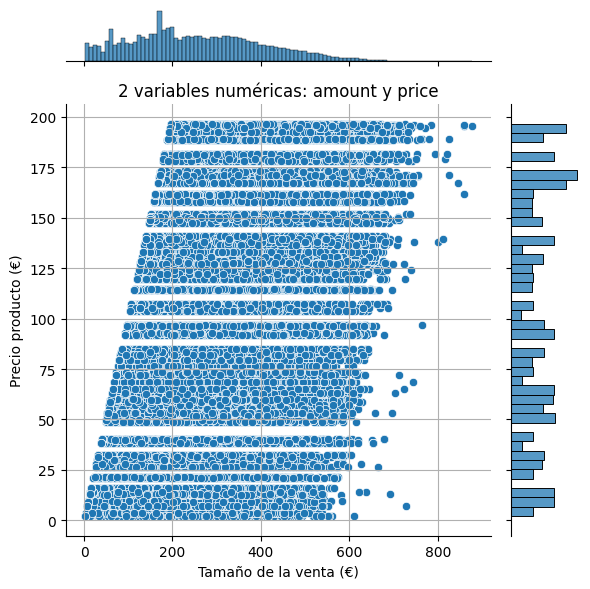

In [13]:
sns.jointplot(
    data=tpu_filtrado,
    x='amount',
    y='price',
    kind='scatter'
)
plt.grid()
plt.title('2 variables numéricas: amount y price')
plt.xlabel('Tamaño de la venta (€)')
plt.ylabel('Precio producto (€)')
plt.tight_layout()
plt.show()
plt.close()

Volvemos a confirmar que no podemos tener ventas de cierto tamaño para productos de precio mayor a la venta. También observamos mayor parte de las ventas són menores a 400 € y decaen a mayor tamaño. Y el precio de producto que más aparece es alrededor de 170 €, seguido de valores similares o mayores, no precios bajos.


## Nivell 3

### 1. 
Transfereix totes les visualitzacions del Nivell 1 a Power BI utilitzant scripts de Python.